In [2]:
import pandas as pd
import numpy as np
# Load the data
combined_df = pd.read_csv('dataset/Combined-Preprocessed-Dataset.csv')
combined_df.head()

,uid,text,label,extracted_features
0,[urlsf_subset00]-[83],The National Weather Service's Mike McFarland ...,1,[-5.11931144e-02 1.16266675e-01 2.12036110e-...
1,[urlsf_subset00]-[89],The President of the United States was seen on...,1,[-6.35785013e-02 7.72023574e-02 1.69519372e-...
2,[urlsf_subset00]-[390],Enner Valencia scored two goals in Ecuador's 2...,1,[-4.60926928e-02 1.01213977e-01 2.46110968e-...
3,[urlsf_subset00]-[457],"Beginning with the introduction, the author sh...",1,[-6.40455633e-02 1.29315838e-01 -8.56540399e-...
4,[urlsf_subset00]-[458],Mexico has implemented its newest data retenti...,1,[-2.13616956e-02 1.00920901e-01 1.86153129e-...


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'])

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=512)

2023-09-26 02:37:34.977126: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 02:37:35.032423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 02:37:35.854223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']), 
    torch.tensor(train_encodings['attention_mask']), 
    torch.tensor(train_df['label'].tolist())
)

val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']), 
    torch.tensor(val_encodings['attention_mask']), 
    torch.tensor(val_df['label'].tolist())
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']), 
    torch.tensor(test_encodings['attention_mask']), 
    torch.tensor(test_df['label'].tolist())
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [6]:
# Step 5: Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Initialize lists to store metrics
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []
train_precision_values = []
val_precision_values = []
train_f1_values = []
val_f1_values = []
epochs = 3
# Training Loop with Evaluation
for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    train_predictions, train_true_labels = [], []
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        logits = outputs.logits
        train_predictions.extend(torch.argmax(logits, axis=1).tolist())
        train_true_labels.extend(labels.tolist())

    avg_train_loss = total_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_precision = precision_score(train_true_labels, train_predictions)
    train_f1 = f1_score(train_true_labels, train_predictions)

    train_accuracy_values.append(train_accuracy)
    train_precision_values.append(train_precision)
    train_f1_values.append(train_f1)

    # Validation
    model.eval()
    total_val_loss = 0
    val_predictions, val_true_labels = [], []
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        total_val_loss += outputs.loss.item()
        logits = outputs.logits
        val_predictions.extend(torch.argmax(logits, axis=1).tolist())
        val_true_labels.extend(labels.tolist())
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_precision = precision_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions)

    val_accuracy_values.append(val_accuracy)
    val_precision_values.append(val_precision)
    val_f1_values.append(val_f1)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss_values[-1]:.4f}, Train Accuracy: {train_accuracy_values[-1]:.4f}, Train Precision: {train_precision_values[-1]:.4f}, Train F1: {train_f1_values[-1]:.4f}")
    print(f"Val Loss: {val_loss_values[-1]:.4f}, Val Accuracy: {val_accuracy_values[-1]:.4f}, Val Precision: {val_precision_values[-1]:.4f}, Val F1: {val_f1_values[-1]:.4f}")
    print('-----------------------------------')

Epoch 1/3
Train Loss: 0.0727, Train Accuracy: 0.9718, Train Precision: 0.9759, Train F1: 0.9718
Val Loss: 0.0402, Val Accuracy: 0.9861, Val Precision: 0.9857, Val F1: 0.9862
-----------------------------------
Epoch 2/3
Train Loss: 0.0285, Train Accuracy: 0.9904, Train Precision: 0.9899, Train F1: 0.9905
Val Loss: 0.0396, Val Accuracy: 0.9893, Val Precision: 0.9856, Val F1: 0.9894
-----------------------------------
Epoch 3/3
Train Loss: 0.0177, Train Accuracy: 0.9941, Train Precision: 0.9943, Train F1: 0.9942
Val Loss: 0.0511, Val Accuracy: 0.9862, Val Precision: 0.9760, Val F1: 0.9864
-----------------------------------


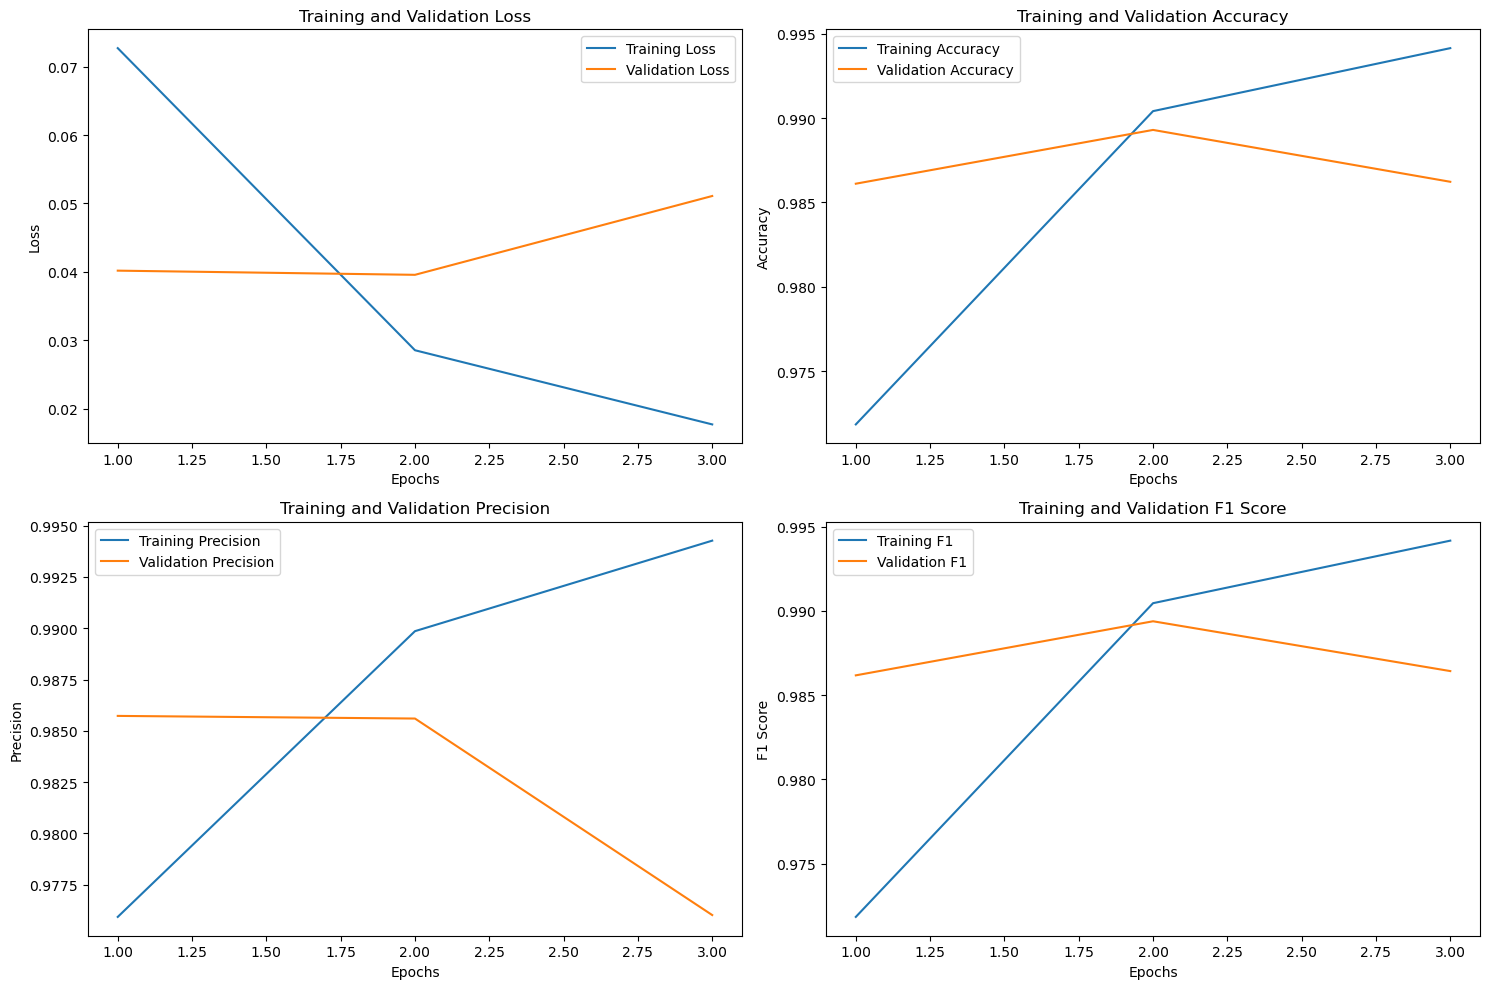

In [7]:
# Plotting metrics
epochs = range(1, 4)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precision_values, label='Training Precision')
plt.plot(epochs, val_precision_values, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_values, label='Training F1')
plt.plot(epochs, val_f1_values, label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

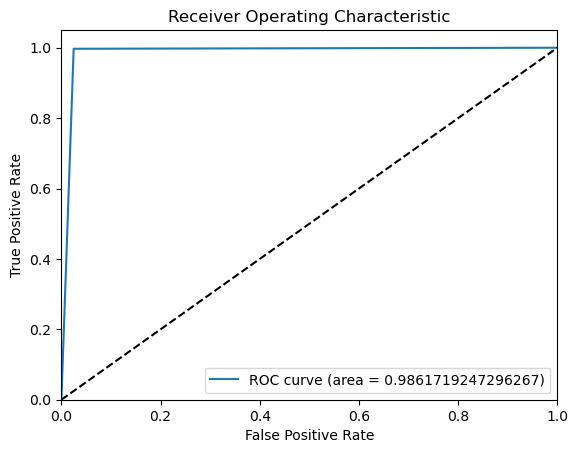

Accuracy: 0.9862202482632958
Precision: 0.9760266370699223
Recall: 0.9970521541950114
F1 Score: 0.9864273696017948
AUROC: 0.9861719247296267
EER: 0.024182091330500918


In [8]:
# Step 6: Evaluation
model.eval()
predictions, true_labels = [], []
for batch in test_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, axis=1).tolist())
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auroc = roc_auc_score(true_labels, predictions)
fpr, tpr, _ = roc_curve(true_labels, predictions)
eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

# Plotting ROC and DET Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auroc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'''Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}
AUROC: {auroc}
EER: {eer}''')


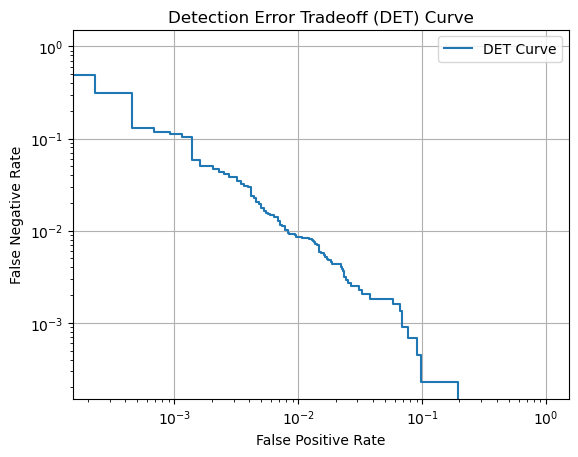

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_det_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    plt.figure()
    plt.plot(fpr, fnr, label='DET Curve')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')
    plt.title('Detection Error Tradeoff (DET) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# During the evaluation phase, keep track of the raw scores (before thresholding to 0 or 1) like so:
raw_scores = []
for batch in val_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    raw_scores.extend(logits[:, 1].cpu().numpy())  # Assuming label '1' is the positive class

# Then, plot the DET curve:
plot_det_curve(true_labels, raw_scores)


In [10]:
# Save the model weights
torch.save(model.state_dict(), 'RobertaClassifierOpenGPT.pth')
